
# Vancouver, BC Crime Data Analysis (2003–2023)

This project analyzes 20 years of crime data in Vancouver, BC, covering temporal and spatial trends. Using Python-based data analysis and geospatial visualization, we explore crime types, time patterns, and hotspots to support tactical decision-making and proactive policing.

### Dataset Overview

- **Source**: Geospatial crime incident dataset, Vancouver Open Data
- **Period**: 2003 to November 2023
- **Fields**:
  - `TYPE`: Crime category
  - `YEAR`, `MONTH`, `DAY`, `HOUR`, `MINUTE`: Timestamp
  - `NEIGHBOURHOOD`: Census-based neighborhood
  - `HUNDRED_BLOCK`: General location
  - `X`, `Y`: UTM coordinates



### Importing Required Libraries

In [1]:
!pip install geopandas


In [2]:
!pip install folium


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import folium
from folium.plugins import HeatMap


# Set display options
pd.set_option('display.max_columns', None)


### Load the Dataset

In [20]:
df = pd.read_csv("vancouver_crime_data.csv")
df.head()


,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,491285.0000,5.453433e+06
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.9648,5.457110e+06
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491004.8164,5.459177e+06
3,Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.7798,5.459174e+06
4,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9434,5.459166e+06


###  Data Summary

In [24]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881242 entries, 0 to 881241
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TYPE           881242 non-null  object 
 1   YEAR           881242 non-null  int64  
 2   MONTH          881242 non-null  int64  
 3   DAY            881242 non-null  int64  
 4   HOUR           881242 non-null  int64  
 5   MINUTE         881242 non-null  int64  
 6   HUNDRED_BLOCK  881230 non-null  object 
 7   NEIGHBOURHOOD  881099 non-null  object 
 8   X              881167 non-null  float64
 9   Y              881167 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 67.2+ MB


In [25]:
df.describe()

,YEAR,MONTH,DAY,HOUR,MINUTE,X,Y
count,881242.000000,881242.000000,881242.000000,881242.000000,881242.000000,881167.000000,8.811670e+05
mean,2012.280981,6.522766,15.384418,12.310825,15.863388,448947.150399,4.977180e+06
std,6.192852,3.393490,8.753394,7.464861,18.361709,139392.826517,1.545107e+06
min,2003.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2007.000000,4.000000,8.000000,7.000000,0.000000,490187.175900,5.454209e+06
50%,2012.000000,7.000000,15.000000,14.000000,5.000000,491569.941200,5.457169e+06
75%,2018.000000,9.000000,23.000000,18.000000,30.000000,493380.107600,5.458718e+06
max,2023.000000,12.000000,31.000000,23.000000,59.000000,511303.000000,5.512579e+06


In [26]:
df.isnull().sum()

TYPE               0
YEAR               0
MONTH              0
DAY                0
HOUR               0
MINUTE             0
HUNDRED_BLOCK     12
NEIGHBOURHOOD    143
X                 75
Y                 75
dtype: int64

### Convert UTM to Latitude & Longitude 

In [28]:
!pip install utm


  Obtaining dependency information for utm from https://files.pythonhosted.org/packages/3b/a4/0698f3e5c397442ec9323a537e48cc63b846288b6878d38efd04e91005e3/utm-0.8.1-py3-none-any.whl.metadata


In [29]:
import utm

def convert_utm(row):
    try:
        lat, lon = utm.to_latlon(row['X'], row['Y'], 10, 'U')
        return pd.Series([lat, lon])
    except:
        return pd.Series([np.nan, np.nan])

df[['Latitude', 'Longitude']] = df.apply(convert_utm, axis=1)


In [31]:
df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,491285.0000,5.453433e+06,49.233614,-123.119712
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.9648,5.457110e+06,49.266678,-123.129029
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491004.8164,5.459177e+06,49.285281,-123.123690
3,Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.7798,5.459174e+06,49.285255,-123.123649
4,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9434,5.459166e+06,49.285181,-123.123536


### Crime Trend Overview (2003–2023)

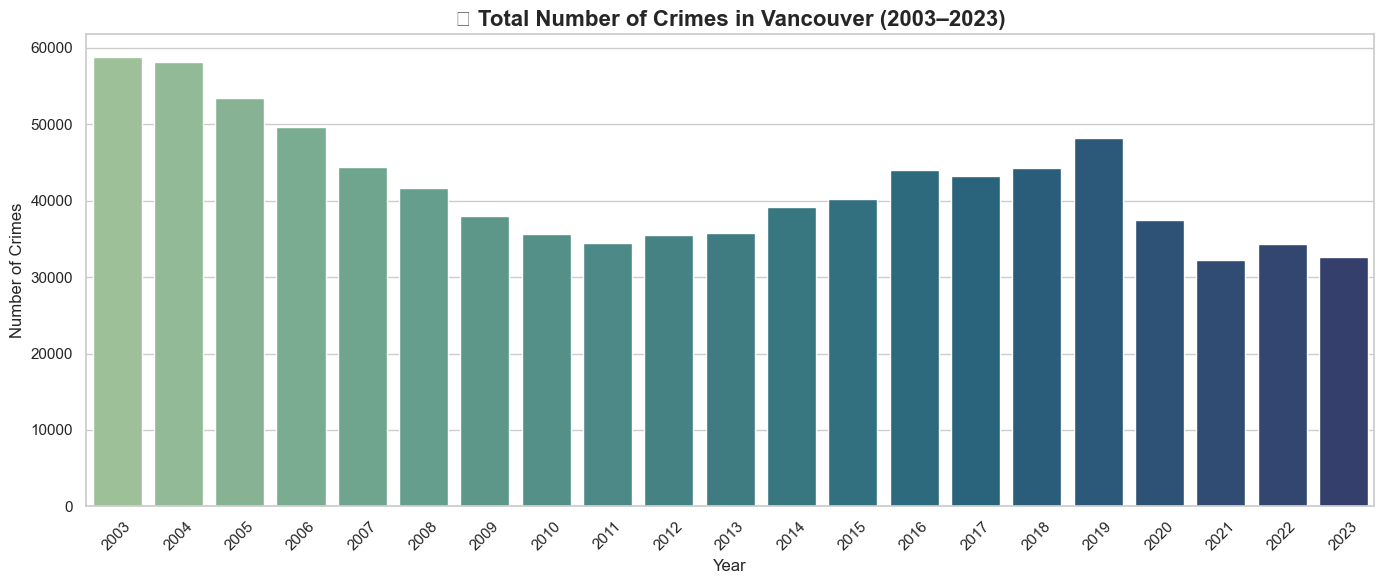

In [8]:
# Total Number of Crimes in Vancouver (2003-2023)
# Filter data from 2003 to 2020
df_filtered = df[(df['YEAR'] >= 2003) & (df['YEAR'] <= 2023)]

# Count crimes per year
crimes_per_year = df_filtered['YEAR'].value_counts().sort_index()

# Set seaborn theme for better style
sns.set_theme(style="whitegrid")

# Create the barplot
plt.figure(figsize=(14, 6))
sns.barplot(
    x=crimes_per_year.index,
    y=crimes_per_year.values,
    palette="crest"  # beautiful color palette
)

# Add titles and labels
plt.title("📊 Total Number of Crimes in Vancouver (2003–2023)", fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Crimes", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


 Result: Crime numbers generally peaked in early 2010s, with some decline or plateau post-2020.

### Top 10 Crime Types

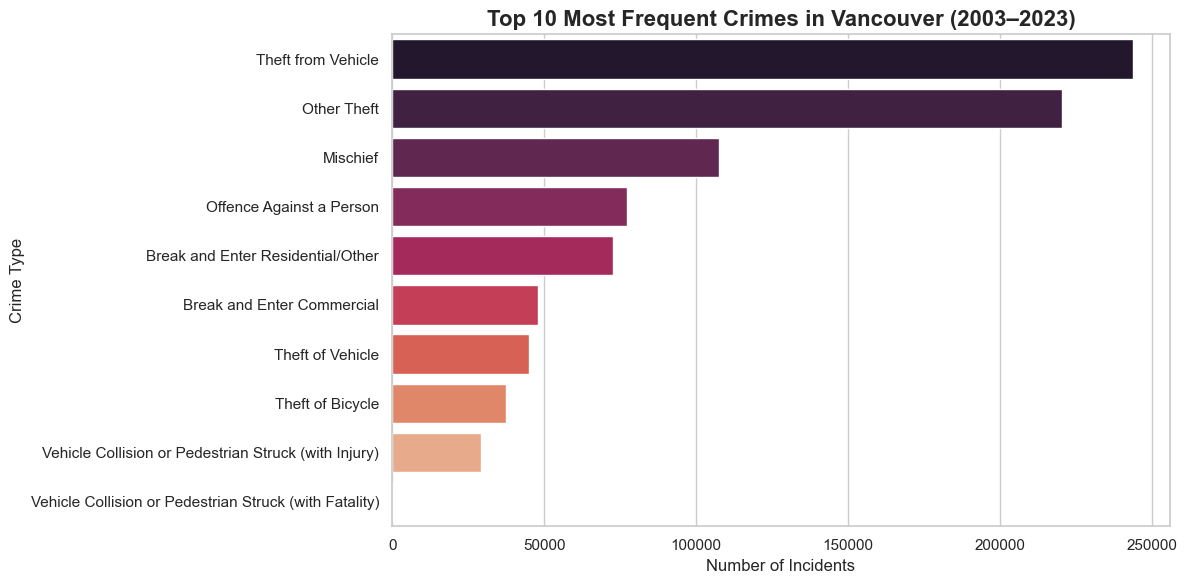

In [9]:
# Count crime occurrences from 2003 to 2023
crime_counts = df['TYPE'].value_counts()

# Plot top 10 most frequent crimes
top_n = 10
top_crimes = crime_counts.head(top_n)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,6))
sns.barplot(
    x=top_crimes.values,
    y=top_crimes.index,
    palette="rocket"
)

plt.title(f"Top {top_n} Most Frequent Crimes in Vancouver (2003–2023)", fontsize=16, weight='bold')
plt.xlabel("Number of Incidents", fontsize=12)
plt.ylabel("Crime Type", fontsize=12)
plt.tight_layout()

plt.show()


**Result:** Most common offenses are Theft, Mischief, and Break & Enter.



### Monthly Trends

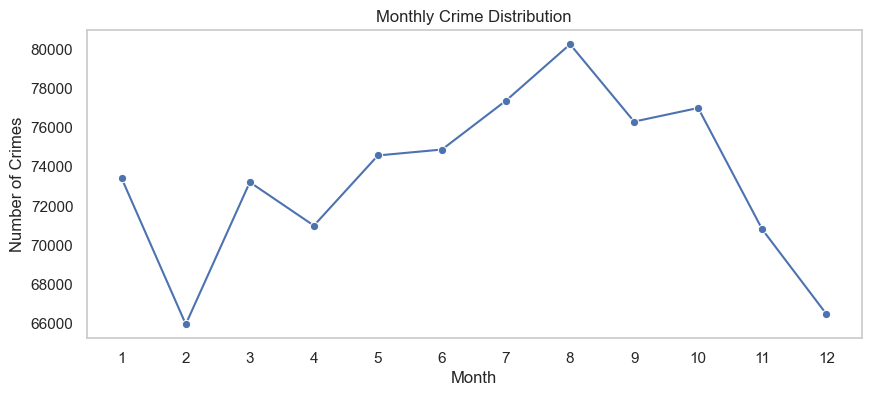

In [33]:
monthly_crime = df.groupby("MONTH").size()

plt.figure(figsize=(10, 4))
sns.lineplot(x=monthly_crime.index, y=monthly_crime.values, marker="o")
plt.title("Monthly Crime Distribution")
plt.xlabel("Month")
plt.ylabel("Number of Crimes")
plt.grid()
plt.xticks(range(1,13))
plt.show()


**Result:** Crimes often rise during summer months (July–August).

### Day of Month & Day of Week

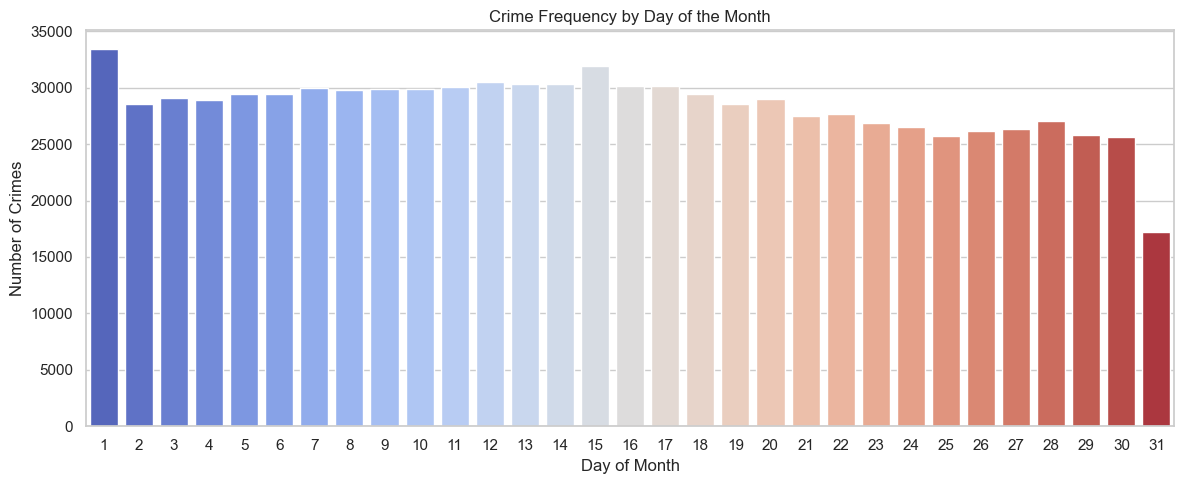

In [11]:
plt.figure(figsize=(12, 5))
sns.countplot(x='DAY', data=df, palette='coolwarm')
plt.title('Crime Frequency by Day of the Month')
plt.xlabel('Day of Month')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


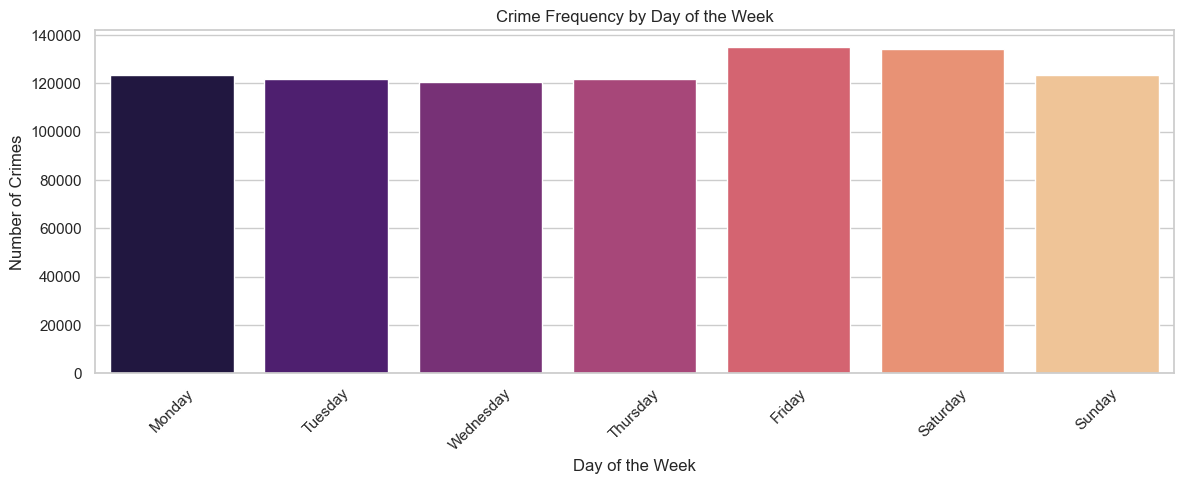

In [12]:
# Convert to datetime if needed
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df['WEEKDAY'] = df['DATE'].dt.day_name()
# Order days manually
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 5))
sns.countplot(x='WEEKDAY', data=df, order=order, palette='magma')
plt.title('Crime Frequency by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 **Result:** Higher crime rates on weekends, especially Friday and Saturday.

### Crime by Hour of the Day

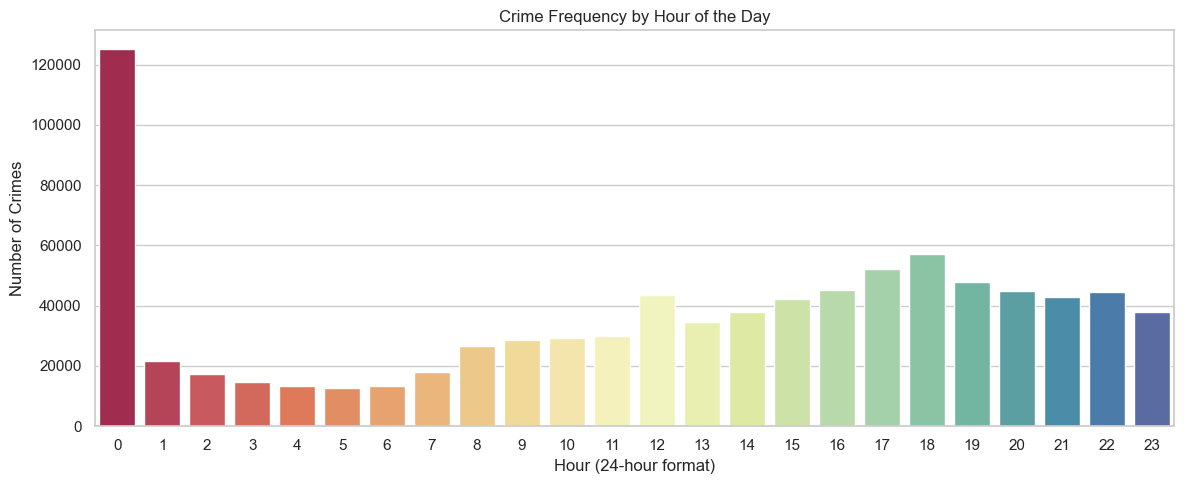

In [13]:
plt.figure(figsize=(12, 5))
sns.countplot(x='HOUR', data=df, palette='Spectral')
plt.title('Crime Frequency by Hour of the Day')
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Number of Crimes')
plt.tight_layout()
plt.show()


**Result:** Peak crime activity between 6 PM – 12 AM.

### Top 10 High-Crime Neighbourhoods

In [14]:
# Top 10 neighbourhoods by number of crimes
top_neighbourhoods = df['NEIGHBOURHOOD'].value_counts().head(10)
print(top_neighbourhoods)


NEIGHBOURHOOD
Central Business District    237708
West End                      79002
Strathcona                    56811
Mount Pleasant                55494
Fairview                      53908
Grandview-Woodland            49388
Renfrew-Collingwood           47438
Kitsilano                     42923
Kensington-Cedar Cottage      41705
Hastings-Sunrise              30324
Name: count, dtype: int64


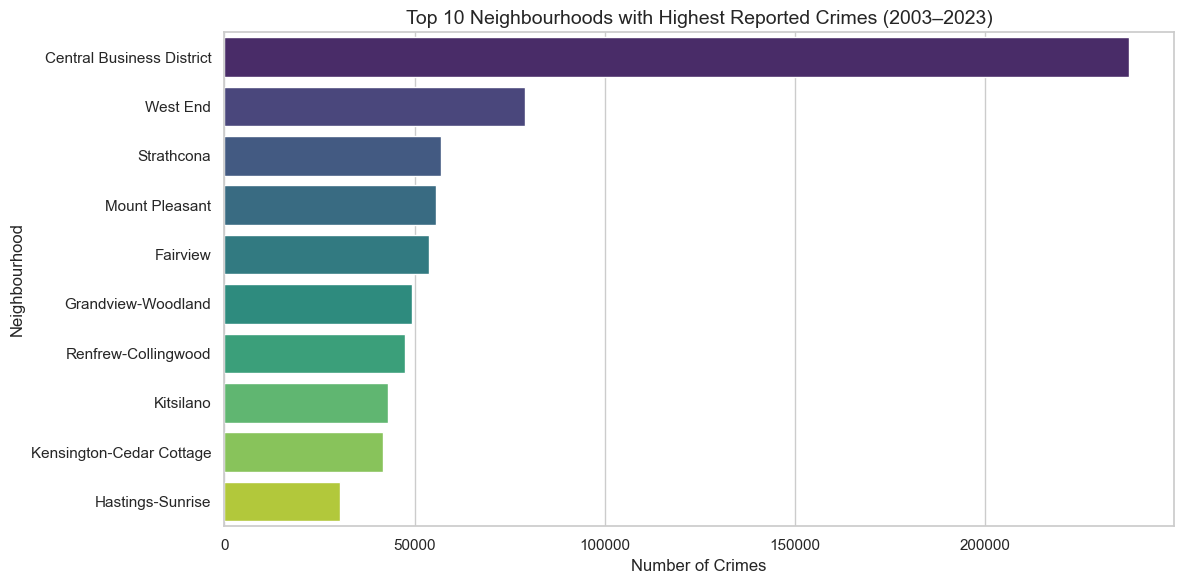

In [15]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_neighbourhoods.values, y=top_neighbourhoods.index, palette="viridis")
plt.title('Top 10 Neighbourhoods with Highest Reported Crimes (2003–2023)', fontsize=14)
plt.xlabel('Number of Crimes')
plt.ylabel('Neighbourhood')
plt.tight_layout()
plt.show()


**Result:** Downtown, Mount Pleasant, and Grandview-Woodland show the highest crime numbers.

### Geospatial Mapping of Crime Incidents

In [16]:
import folium

crime_map = folium.Map(location=[49.2827, -123.1207], zoom_start=12)

for _, row in df.sample(200).iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=2,
        color='red',
        fill=True,
        fill_opacity=0.5
    ).add_to(crime_map)

crime_map


### Crime Hotspot Detection (Heatmap)

In [17]:
from folium.plugins import HeatMap

heat_df = df[['Latitude', 'Longitude']].dropna()

m = folium.Map(location=[49.2827, -123.1207], zoom_start=12)
HeatMap(data=heat_df.sample(1000)).add_to(m)
m


**Result:** Heatmap shows strong clustering around downtown and central neighborhoods.

### Final Summary & Insights

### 🔍 Key Takeaways

- **Most Common Crimes**: Theft, Mischief, and B&E dominate the crime landscape.
- **When Crimes Occur**:
  - **Time**: Highest in the evening (6 PM – midnight).
  - **Days**: Friday and Saturday see more incidents.
  - **Months**: Summer spikes in July–August.
- **Where Crimes Occur**:
  - **Top Areas**: Downtown, Mount Pleasant, Grandview-Woodland
  - **Heatmap** confirms high density in core neighborhoods.

### 🚔 Tactical Use

This analysis can help law enforcement allocate resources, anticipate surges, and create targeted patrol strategies.
